# **Predicting 10-Year Coronary Heart Disease (CHD) Risk**  

##### Cardiovascular diseases are the `leading` global `cause of death`, with `coronary heart disease (CHD)` as the most prevalent, accounting for `13% of global deaths` from 2000 to 2021 ([WHO](https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates/ghe-leading-causes-of-death)). For instance, in the U.S., nearly half of adults have at least one major CHD risk factor—high blood pressure, high cholesterol, or smoking ([NHLBI](https://www.nhlbi.nih.gov/health/coronary-heart-disease/risk-factors)). The `goal of the project` is to develop a `logistic regression model` to estimate an individual's `10-year CHD probability`, optimizing predictive accuracy, interpretability, and classification effectiveness. The analysis relies on a [Kaggle dataset](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea), allegedly linked to the [Framingham Heart Study](https://www.framinghamheartstudy.org/fhs-about/), a cornerstone in cardiovascular research.
  
##### **Project Roadmap**  

| **Section** | **Objective** |
|------------|--------------|
| 1. Data Cleaning | Load the dataset, inspect structure, and handle duplicates and missing values. |
| 2. Exploratory Data Analysis (EDA) | Examine feature distributions, assess correlations, detect & analyze outliers, and evaluate multicollinearity. |
| 3. Data Preprocessing | Encode categorical variables, split data into training and testing sets, apply appropriate scaling, handle outliers, and finalize preprocessing steps before modeling. |
| 4. Modeling & Evaluation | Train a logistic regression model, optimize classification threshold, and validate performance on the test set. |
| 5. Interpretation & Considerations | Analyze feature importance, assess generalizability, and discuss dataset limitations. |

<br>

---

## **1. Data Cleaning**  

 ##### The dataset is `loaded and inspected` to understand its composition and detect `missing values` or `duplicates`. Missing data is handled using appropriate imputation techniques to minimize information loss. 

### **1.1. Imports & Configurations**

In [1181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve
)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

sns.set_theme(
    style="ticks",
    palette="pastel",
    rc={
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 9,
        "axes.edgecolor": "lightblue",
    }
)

plt.rcParams["legend.frameon"] = False  

### **1.2. Load & Inspect Data**

In [1182]:
df = pd.read_csv("train.csv")
print(f"Dataset contains {df.shape[0]} observations and {df.shape[1]} features.")

Dataset contains 3390 observations and 17 features.


In [1183]:
df.dtypes

id                   int64
age                  int64
education          float64
sex                 object
is_smoking          object
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [1184]:
df.sample(5, random_state=42)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
134,134,64,1.00,F,NO,0.00,0.00,0,1,1,262.00,147.00,90.00,26.51,85.00,173.00,0
1764,1764,36,2.00,M,YES,20.00,0.00,0,1,0,248.00,135.00,94.50,36.52,65.00,85.00,0
2465,2465,61,1.00,M,YES,13.00,0.00,0,0,0,312.00,110.00,66.00,26.28,68.00,96.00,0
1987,1987,51,2.00,F,NO,0.00,0.00,0,0,0,233.00,120.00,81.00,28.25,80.00,75.00,0
1295,1295,59,4.00,M,YES,20.00,0.00,0,1,0,232.00,151.50,110.00,26.89,68.00,69.00,0


- `education` is stored as `float64`, though it represents an ordinal category, requiring further review. `BPMeds`, a binary variable, is unexpectedly float64 and needs verification.

- `sex` and `is_smoking` are categorical but stored as `object`, requiring conversion. `id` is a non-informative column and is dropped.

In [1185]:
df.drop(columns=["id"], inplace=True)

Checking `unique values per variable` helps ensure precise feature classification—nominal, ordinal, binary, or continuous—guiding appropriate encoding, scaling, and transformation strategies critical for model performance and interpretability.

In [1186]:
df.nunique().to_frame("Unique Values")

,Unique Values
age,39
education,4
sex,2
is_smoking,2
cigsPerDay,32
BPMeds,2
prevalentStroke,2
prevalentHyp,2
diabetes,2
totChol,240


In [1187]:
for col in ["education", "sex", "is_smoking", "BPMeds"]:
    unique_vals = df[col].dropna().unique()
    print(f"{col} ({df[col].dtype}): {unique_vals}")

education (float64): [2. 4. 1. 3.]
sex (object): ['F' 'M']
is_smoking (object): ['YES' 'NO']
BPMeds (float64): [0. 1.]


**Feature Classification**

| Type              | Features  | Notes |
|--------------------------------|---------------|-----------|
| Nominal Categorical        | `sex` (Gender: M/F), `is_smoking` (Smoking status: YES/NO) | Needs encoding into `binary categorical` in `int64` |
| Ordinal Categorical        | `education` (Education level: 1-4, ordered but not continuous) | `education` needs casting to `int64`, treated as ordinal categorical |
| Binary Categorical         | `BPMeds` (Blood pressure medication), `prevalentStroke` (Stroke history), `prevalentHyp` (Hypertension history), `diabetes` (Diabetes history), `TenYearCHD` (10-year CHD risk, target variable) | `BPMeds` needs casting to `int64`, treated as binary categorical |
| Continuous Numeric                | `age` (Age in years, treated as continuous), `cigsPerDay` (Cigarettes per day), `totChol` (Total cholesterol level), `sysBP` (Systolic blood pressure), `diaBP` (Diastolic blood pressure), `BMI` (Body Mass Index), `heartRate` (Heart rate in beats per minute), `glucose` (Blood glucose level) | No changes needed, keep as `float64` |

> ⚠️ **Feature value casting will be performed when addressing missing values, while categorical features will be encoded in data preprocessing.** 


### **1.3. Handling Duplicate Observations**

In [1188]:
print(f"\n This dataset has {df.duplicated().sum()} duplicated observations.")


 This dataset has 0 duplicated observations.


### **1.4. Handling Missing Values**

In [1189]:
missing = df.isnull().sum().pipe(lambda x: x[x > 0].sort_values(ascending=False))

print(f"Total missing: {missing.sum()} ({(missing.sum() / df.size * 100):.2f}%)")

display(missing.to_frame("Missing Values").assign(Percentage=lambda x: (x / len(df) * 100).round(2)))


Total missing: 510 (0.94%)


,Missing Values,Percentage
glucose,304,8.97
education,87,2.57
BPMeds,44,1.30
totChol,38,1.12
cigsPerDay,22,0.65
BMI,14,0.41
heartRate,1,0.03


- The dataset has missing values in **7 features**, with `glucose` missing the most **(8.97%)**, requiring careful consideration in terms of diabetic and non-diabetic study participants. `cigsPerDay` will also have to get looked at due to `smoker` and `non-smoker` participants being involved in the study. 

- Other variables, including `education`, `BPMeds`, `totChol`, and `BMI`, have **low missingness (<3%)**, making simple median or mode imputation suitable. `heartRate` has only **one missing value (0.03%)** and can be **safely dropped or imputed without impact**.

#### **1.4.1. Categorical Features (`education`, `BPMeds`)**

`Mode imputation` is best for categorical variables since it replaces missing values with the most common category.

In [1190]:
mode_imputer = SimpleImputer(strategy="most_frequent")

df[["education", "BPMeds"]] = mode_imputer.fit_transform(df[["education", "BPMeds"]])

df["education"] = df["education"].astype(int)
df["BPMeds"] = df["BPMeds"].astype(int)

#### **1.4.2. Numeric Features (`glucose`, `cigsPerDay`, `totChol`, `BMI`, `heartRate`**

Misssing values in `numerical variables` are handled with `median imputation`. Nevertheless, `glucose` and `cigsPerDay` are investigated further to check whether `group-wise median imputation` would be useful to preserve the natural distribution of glucose levels across different health conditions and different smoking habits. 

In this case, instead of a single median, separate median values for `diabetic` and `non-diabetic`, as well as `smoker` and `non-smoker` individuals, might be computed. Let's check `glucose` and `cigsPerday` missing values distribution by category to evaluate further steps.

In [1191]:
missing_cigs = df.groupby("is_smoking")["cigsPerDay"].apply(lambda x: x.isnull().sum())
missing_cigs

is_smoking
NO      0
YES    22
Name: cigsPerDay, dtype: int64

In [1192]:
missing_glucose = df.groupby("diabetes")["glucose"].apply(lambda x: x.isnull().sum())
missing_glucose

diabetes
0    301
1      3
Name: glucose, dtype: int64

- Group-wise median imputation is not required for `cigsPerDay` since missing values are present only among smokers. Instead, the median for smokers will be imputed using `SimpleImputer`
 
- In contrast, missing `glucose` values appear in both `diabetic` and `non-diabetic` groups. Therefore, group-wise median imputation for this feature could be prefferable.

In [1193]:
df["glucose"] = df["glucose"].fillna(df.groupby("diabetes")["glucose"].transform("median"))

The remaining numerical variables are handled with `SimpleImputer`.

In [1194]:
median_imputer = SimpleImputer(strategy="median")
df[["cigsPerDay", "totChol", "BMI", "heartRate"]] = median_imputer.fit_transform(df[["cigsPerDay", "totChol", "BMI", "heartRate"]])

In [1195]:
final_missing_check = df.isnull().sum()
final_missing_check

age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

No more missing values in the dataset! ✅ 

### **1.5. Encoding Categorical Variables**

In [1196]:
df["male"] = df["sex"].map({"F": 0, "M": 1}).astype(int)
df["is_smoking"] = df["is_smoking"].map({"NO": 0, "YES": 1}).astype(int)

df.drop(columns=["sex"], inplace=True)

df.head()

,age,education,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,male
0,64,2,1,3.00,0,0,0,0,221.00,148.00,85.00,25.38,90.00,80.00,1,0
1,36,4,0,0.00,0,0,1,0,212.00,168.00,98.00,29.77,72.00,75.00,0,1
2,46,1,1,10.00,0,0,0,0,250.00,116.00,71.00,20.35,88.00,94.00,0,0
3,50,1,1,20.00,0,0,1,0,233.00,158.00,88.00,28.26,68.00,94.00,1,1
4,64,1,1,30.00,0,0,0,0,241.00,136.50,85.00,26.42,70.00,77.00,0,0


---

## **2. Exploratory Data Analysis**

### **2.1. Target Variable Distribution (`TenYearCHD`)**

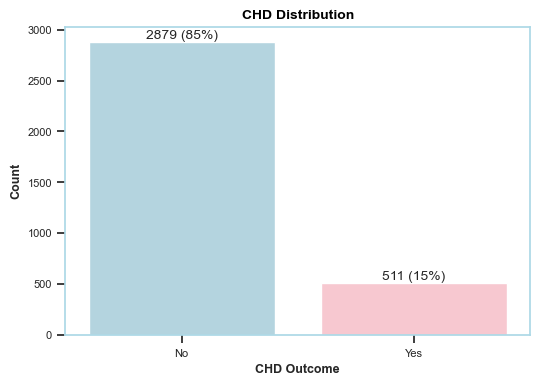

In [1197]:
plt.figure()
ax = sns.countplot(x="TenYearCHD", data=df, hue="TenYearCHD", palette=["lightblue", "pink"], legend=False)

ax.set_xticks([0, 1])
ax.set_xticklabels(["No", "Yes"])

for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f} ({p.get_height() / len(df) * 100:.0f}%)", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="bottom", fontsize=10)

plt.title("CHD Distribution")
plt.xlabel("CHD Outcome")
plt.ylabel("Count")

plt.show()

- The target variable `TenYearCHD` is `moderately imbalanced`, with 85% of individuals not developing CHD and 15% experiencing it within ten years. This imbalance makes `accuracy` an unreliable metric, as a model predicting only CHD = 0 for all cases would still achieve 85% accuracy while failing to identify any actual CHD cases. 

- Therefore, the evaluation will focus on `precision`, `recall`, and `F1-score`, among others, ensuring the model correctly identifies CHD cases (`recall`/`sensitivity`) while minimizing false positives (`precision`) to balance medical risk and predictive accuracy. 

- If the model demonstrates low recall, adjustments such as `resampling` techniques (e.g., SMOTE) or `class weighting` (`class_weight="balanced"`) may be considered, but only if necessary based on evaluation metrics during model optimization.




### **2.2. Independent Variable Distributions**

##### **2.2.1. Categorical Features**

C:\Users\milda\AppData\Local\Temp\ipykernel_5660\1051390010.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm")


KeyError: 'sex'

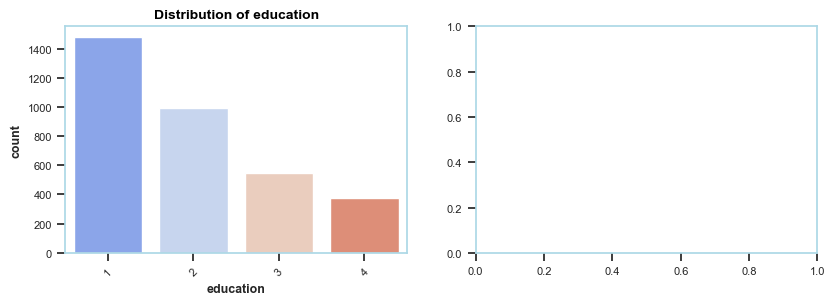

In [1198]:
categorical_features = ["education", "sex", "is_smoking", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]

plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=df[col], palette="coolwarm")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)  # Rotate labels for readability if needed

plt.tight_layout()
plt.show()

##### **2.2.2. Numerical Variables**

In [ ]:
numerical_features = ["age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]

skewness_values = df[numerical_features].skew()

plt.figure(figsize=(20, 6))

for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 8, i)
    sns.histplot(df[col], bins=50, kde=True, color="steelblue")
    skewness = skewness_values[col]
    plt.title(f"Distribution of {col}\nSkewness: {skewness:.2f}")

    plt.subplot(2, 8, i + 8)  # Shifts to second row
    sns.boxplot(x=df[col], orient="h", color="lightgrey")
    plt.title(f"Boxplot of {col}")


plt.tight_layout()
plt.show()

- **High positive skewness** (>1), indicating strong asymmetry was observed in terms of `glucose` (6.40), `cigsPerDay` (1.23), `sysBP` (1.18), and `BMI` (1.03), which have long right tails with a small subset with extreme values that may negatively influence model estimation. Skewness in some of the features may stem from underlying subgroups, such as `diabetics` vs. `non-diabetics`, `smokers` vs. `non-smokers`, and `hypertensive` vs. `non-hypertensive` individuals. Examining distributions within these groups can provide deeper insights.

- **Moderate positive skewness** (from 0.5 to 1) was observed in `totChol` (0.95), `diaBP` (0.72) and `heartRate` (0.68), while `age` (0.23) followed a rather **symmetrical** distribution. 

In [ ]:
subgroup_features = {
    "glucose": "diabetes",
    "cigsPerDay": "is_smoking",
    "sysBP": "prevalentHyp",
}

plt.figure(figsize=(20, 4))

for i, (feature, group) in enumerate(subgroup_features.items(), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[group], y=df[feature], hue=df[group], palette=["lightblue", "pink"], legend=False)
    
    plt.xticks([0, 1], ["No", "Yes"])
    plt.title(f"{feature} distribution by {group}")

plt.tight_layout()
plt.show()

- `Diabetics` exhibit substantially higher glucose levels compared to `non-diabetics`, with a wider spread and more extreme values. However, it seems there are **extreme outliers** of `glucose` even in the context of the `diabetic` group.

- `Non-smokers` consistently have zero cigarette consumption, while `smokers` display a right-skewed distribution with varying levels of smoking intensity. This indicates that the **skewness in `cigsPerDay` is mainly due to the contrast between smokers and non-smokers**, rather than within the smoking group itself. Although a few **unusual values** are seen.

- `Hypertensive` individuals show substantially higher and more variable systolic blood pressure (`sysBP`), with **one extreme outlier**. 

To rule out `data entry irregularities`, let's conduct a `sanity check`, demonstrating whether the `max` values in skewed predictors make sense in a real-world setting.

In [ ]:
df[numerical_features].describe(percentiles=[0.01, 0.5, 0.95, 0.99])


The sanity check revealed several extreme and unlikely values in context of this dataset: 

- Total cholesterol (`totChol`) has a maximum of `696 mg/dL`, while levels [above 200 mg/dL are already considered high](https://www.cdc.gov/cholesterol/about/index.html). Readings approaching 700 mg/dL could be data anomalies rather than true physiological values.

- Systolic blood pressure (`sysBP`) reaches `295 mmHg`, far exceeding [the 180 mmHg threshold for hypertensive crisis, in case of which the American Heart Association suggests to call 911](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings/hypertensive-crisis-when-you-should-call-911-for-high-blood-pressure). Values above `250 mmHg` are uncommon and may indicate a stroke-level crisis or measurement error. Similarly, diastolic blood pressure (`diaBP`) peaks at 142.5 mmHg, well above the normal ≤80 mmHg range.

- `glucose` levels hit `394 mg/dL`, a [critical medical emergency that could indicate diabetic ketoacidosis (DKA)](https://www.mayoclinic.org/diseases-conditions/diabetic-ketoacidosis/symptoms-causes/syc-20371551) or a diabetic coma. Such values could require immediate medical attention.

- `BMI` reaches `56.8`, an extreme obesity level, but [remains biologically possible](https://pmc.ncbi.nlm.nih.gov/articles/PMC9283149/) as BMI goes to a maximum value of 100.

- `cigsPerDay` has a max of 70, which is extremely high even for heavy smokers, but theoretically possible.